In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.ticker import LinearLocator
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
import seaborn as sns
from scipy.interpolate import griddata
from sklearn.manifold import MDS
import torch


from ae_utils.char import LitCVAE

from pcmr.models.gin import LitAttrMaskGIN
from pcmr.data import data
from pcmr.featurizers import FeaturizerBase, DescriptorFeauturizer, VAEFeaturizer, GINFeaturizer, ChemBERTaFeaturizer, ChemGPTFeaturizer

torch.set_float32_matmul_precision('medium')

rc = mpl.rc_params_from_file(mpl.matplotlib_fname(), use_default_template=False)
sns.set_theme(style="white", rc=rc)

/home/degraff/.conda/envs/pcmr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found local copy...
Loading...
Done!


In [206]:
from pathlib import Path
import pandas as pd

CSV_DIR = Path("../results/raw/rogi/tdc+guac/")

df_rogi: pd.DataFrame = pd.concat(map(pd.read_csv, CSV_DIR.iterdir()), ignore_index=True)\
    .rename(columns={"dataset_and_task": "dataset"})\

df_rogi

,features,dataset,rogi,n_valid,thresholds,cg_sds,n_clusters,model,r2,rmse,mae
0,vae,LD50_ZHU,0.102703,7385,"[0.0, 0.0178376017, 0.027855390600000002, 0.03...","[0.1817255744, 0.1817255729, 0.181119825700000...","[7385, 7384, 7288, 6623, 5300, 3870, 2487, 149...",KNN,0.214229,0.848811,0.642045
1,vae,LD50_ZHU,0.102703,7385,"[0.0, 0.0178376017, 0.027855390600000002, 0.03...","[0.1817255744, 0.1817255729, 0.181119825700000...","[7385, 7384, 7288, 6623, 5300, 3870, 2487, 149...",PLS,0.073974,0.922025,0.711783
2,vae,LD50_ZHU,0.102703,7385,"[0.0, 0.0178376017, 0.027855390600000002, 0.03...","[0.1817255744, 0.1817255729, 0.181119825700000...","[7385, 7384, 7288, 6623, 5300, 3870, 2487, 149...",RF,0.262092,0.822838,0.630770
3,vae,LD50_ZHU,0.102703,7385,"[0.0, 0.0178376017, 0.027855390600000002, 0.03...","[0.1817255744, 0.1817255729, 0.181119825700000...","[7385, 7384, 7288, 6623, 5300, 3870, 2487, 149...",SVR,0.111062,0.903396,0.667822
4,vae,LD50_ZHU,0.102703,7385,"[0.0, 0.0178376017, 0.027855390600000002, 0.03...","[0.1817255744, 0.1817255729, 0.181119825700000...","[7385, 7384, 7288, 6623, 5300, 3870, 2487, 149...",MLP,0.152554,0.881880,0.688188
...,...,...,...,...,...,...,...,...,...,...,...
445,descriptor,SCAFFOLD HOP,0.084902,10000,"[0.0, 0.0, 0.0106091976, 0.0206102781, 0.03062...","[0.3073582483, 0.3073503805, 0.3072341189, 0.3...","[10000, 9991, 9945, 9679, 9042, 7840, 6466, 52...",KNN,0.710771,0.013757,0.010100
446,descriptor,SCAFFOLD HOP,0.084902,10000,"[0.0, 0.0, 0.0106091976, 0.0206102781, 0.03062...","[0.3073582483, 0.3073503805, 0.3072341189, 0.3...","[10000, 9991, 9945, 9679, 9042, 7840, 6466, 52...",PLS,0.709483,0.013789,0.010476
447,descriptor,SCAFFOLD HOP,0.084902,10000,"[0.0, 0.0, 0.0106091976, 0.0206102781, 0.03062...","[0.3073582483, 0.3073503805, 0.3072341189, 0.3...","[10000, 9991, 9945, 9679, 9042, 7840, 6466, 52...",RF,0.750922,0.012766,0.009283
448,descriptor,SCAFFOLD HOP,0.084902,10000,"[0.0, 0.0, 0.0106091976, 0.0206102781, 0.03062...","[0.3073582483, 0.3073503805, 0.3072341189, 0.3...","[10000, 9991, 9945, 9679, 9042, 7840, 6466, 52...",SVR,-2.731628,0.049390,0.044527


In [26]:
desc = DescriptorFeauturizer()
gin = GINFeaturizer(
    model=LitAttrMaskGIN.load("../models/GIN/zinc/"), num_workers=8
)
vae = VAEFeaturizer(
    model=LitCVAE.load("../models/VAE/zinc/"), num_workers=8
)
bert = ChemBERTaFeaturizer()
gpt = ChemGPTFeaturizer()

FEATURIZERS = [desc, gin, vae, bert, gpt]
FEATURE_NAMES = dict(gin='GIN', vae='VAE', chemberta='ChemBERTa', chemgpt='ChemGPT')

Some weights of the model checkpoint at DeepChem/ChemBERTa-77M-MLM were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be 

In [295]:
def knn(smi: str, smis: list[str], f: FeaturizerBase, k: int) -> np.ndarray:
    x = f([smi])
    X = f(smis)
    d = np.sqrt(np.sum(np.square(X - x), -1))

    return np.argsort(d)[1:k+1]

def plot_3d_surface(X: np.ndarray, y: np.ndarray, zlabel = None, ax = None):
    """from https://github.com/coleygroup/rogi-results/blob/main/landscapes_viz.ipynb"""

    ax = ax or plt.axes(projection="3d")
    X_r = MDS(random_state=15, n_jobs=8).fit_transform(X)
    x, y, z = X_r[:, 0], X_r[:, 1], Y

    dx = 1000j
    grid_x, grid_y = np.mgrid[x.min():x.max():dx, y.min():y.max():dx]
    grid_z = griddata(X_r, z, (grid_x, grid_y), method='linear', rescale=True)

    ax.plot_surface(
        grid_x, grid_y, grid_z,
        cmap='coolwarm', lw=0, rcount=100, ccount=100, alpha=0.9,
        vmin=z.min(), vmax=z.max()
    )

    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    ax.set_zlim(z.min(), z.max())
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel(r'$z_1$', labelpad=-6)
    ax.set_ylabel(r'$z_2$', labelpad=-6)
    
    ax.view_init(27.5, -70)

    return ax

In [298]:
DATASET = "scaffold hop".upper()
LABEL = "Z"
# r"Caco-2 permeability (cm$\cdot\mathrm{s}^{-1}$)"

df = data.get(DATASET).sample(1000)
Xs = [f(df.smiles.values.tolist()).astype(float) for f in FEATURIZERS]
Y = df.y.values

Predicting DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 13.83it/s]


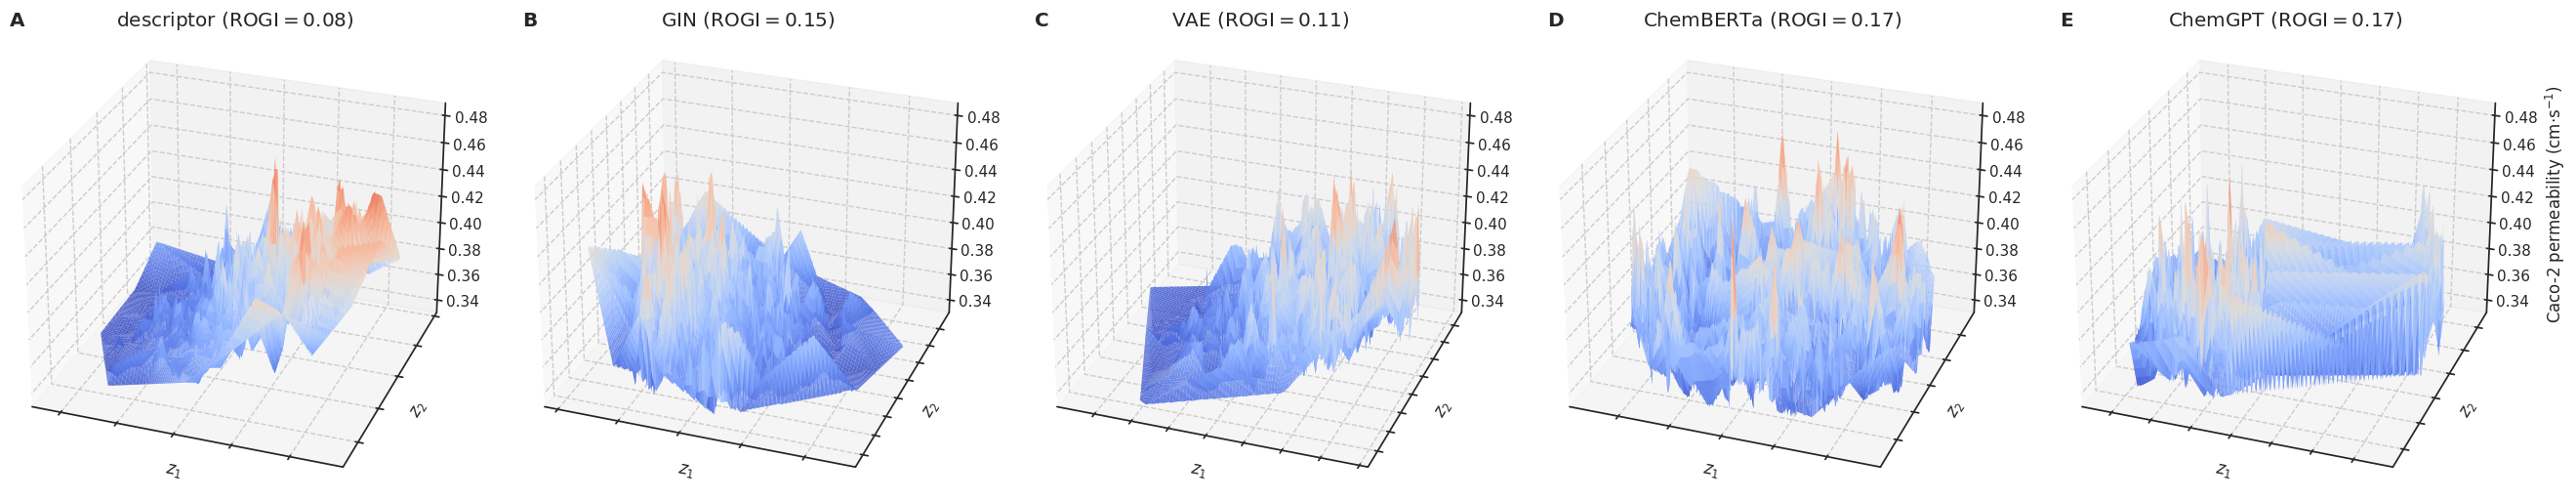

In [299]:
fig, axs = plt.subplots(
    1, len(FEATURIZERS), figsize=(7 * len(FEATURIZERS), 6),
    subplot_kw=dict(projection='3d')
)

for X, f, ax, c in zip(Xs, FEATURIZERS, axs, "ABCDE"):
    plot_3d_surface(X, Y, None, ax)
    rogi = df_rogi.query(f"dataset == '{DATASET}' and features == '{f.alias}'").rogi.mean()
    title = rf"{FEATURE_NAMES.get(f.alias, f.alias)} ($\mathrm{{ROGI}}={rogi:0.2f}$)"
    ax.set_title(title, fontsize="large")
    ax.set_title(c, fontsize="large", fontweight="bold", loc="left")
    ax.dist = 9

fig.supylabel(LABEL, x=0.8825, y=0.59, fontsize="medium", ha='right')
fig.subplots_adjust(left=0., right=1., wspace=-0.625)

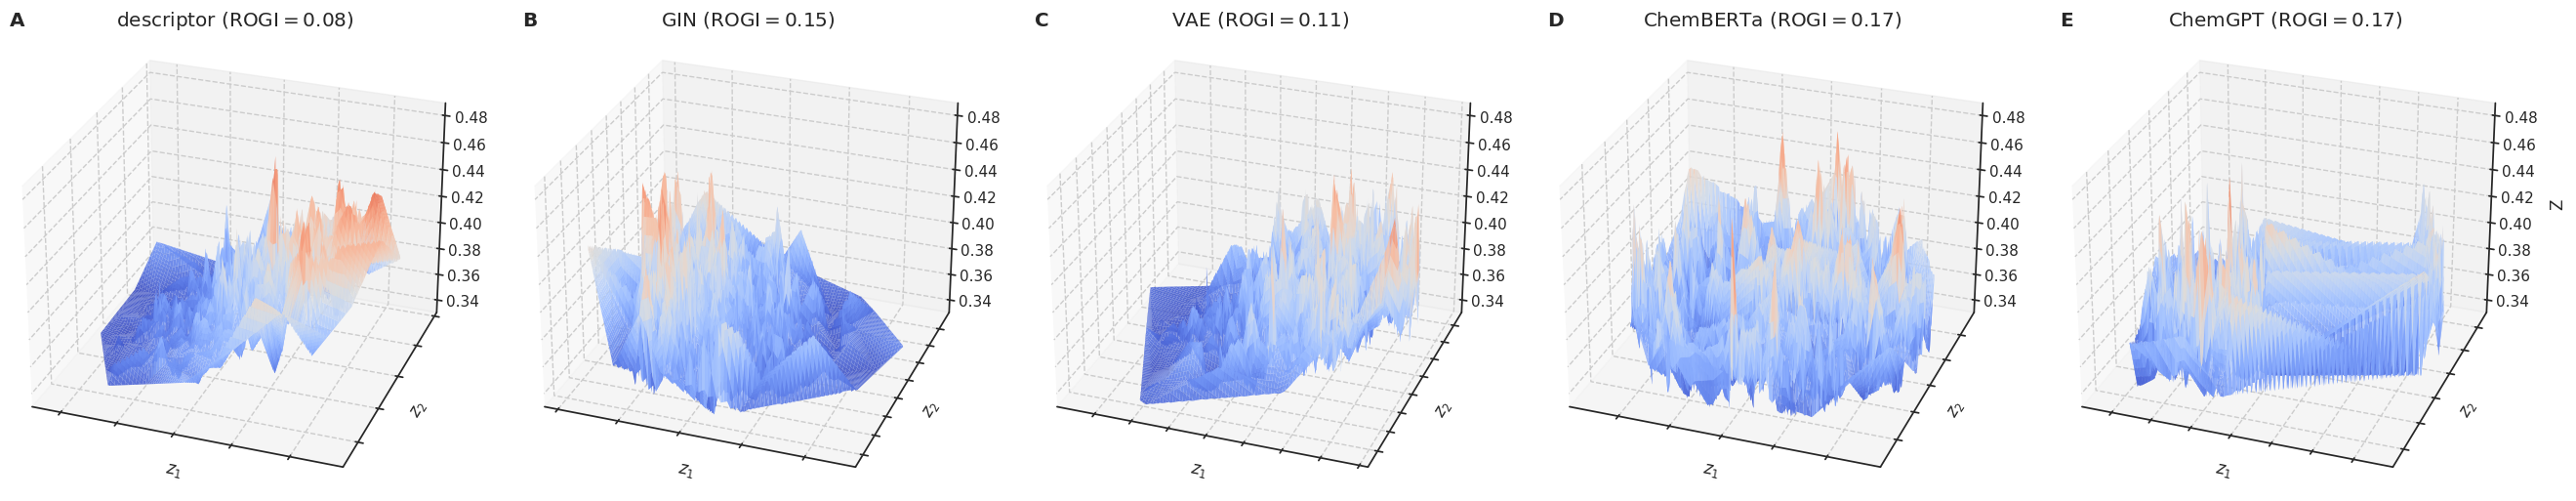

In [301]:
fig.supylabel(r"Z", x=0.8825, y=0.59, fontsize="medium", ha='right')
fig

In [305]:
fig.savefig("../results/figures/landscape_scaffold_hop.png", dpi=450, bbox_inches="tight")

## GRAVEYARD

(667, 384)
(667, 384)
[2.8319571e-03 2.9478646e-03 2.8261731e+00 2.8588619e+00 2.9278393e+00
 2.9963121e+00 3.0303574e+00 3.0367398e+00 3.0447912e+00 3.0767395e+00
 3.1153779e+00 3.1762893e+00 3.2243221e+00 3.2571042e+00 3.2922075e+00
 3.3039873e+00 3.3787007e+00 3.4061687e+00 3.4109669e+00 3.4118207e+00
 3.4176207e+00 3.4349885e+00 3.4349885e+00 3.4733205e+00 3.5152817e+00
 3.5307908e+00 3.5569024e+00 3.5636683e+00 3.5764728e+00 3.5778332e+00
 3.5838349e+00 3.6075599e+00 3.6165652e+00 3.6327105e+00 3.6470518e+00
 3.6483459e+00 3.7067113e+00 3.7126122e+00 3.7229059e+00 3.7475328e+00
 3.7867696e+00 3.7978036e+00 3.8549109e+00 3.8612149e+00 3.8697004e+00
 3.9038038e+00 3.9215710e+00 3.9246721e+00 3.9838505e+00 4.0143561e+00
 4.0531154e+00 4.1412854e+00 4.3710132e+00 4.4161601e+00 4.5230365e+00
 4.5415454e+00 4.5590758e+00 4.9360657e+00 5.1015677e+00 5.4455762e+00
 5.4714327e+00 5.7060800e+00 5.7294946e+00 5.7747035e+00 5.7981830e+00
 5.8041606e+00 5.8155761e+00 5.8881350e+00 5.9147134e+0

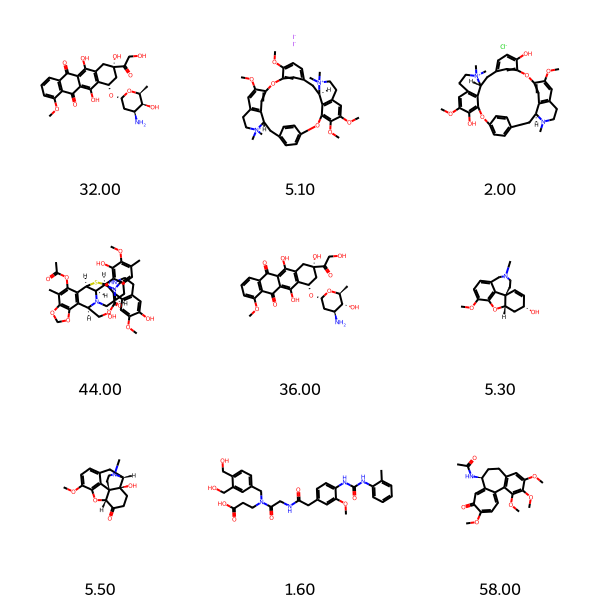

In [ ]:
N = 3

idxs = knn(smi, df.smiles.values.tolist(), bert, N**2 - 1)
neighbors = df.iloc[idxs]

mols = [Chem.MolFromSmiles(s) for s in neighbors.smiles]
ys = neighbors.y.values.tolist()

mols.insert(N**2 // 2, Chem.MolFromSmiles(smi))
ys.insert(N**2 // 2, y)
legends = [f"{y:0.2f}" for y in ys]

img = Draw.MolsToGridImage(mols, molsPerRow=N, subImgSize=(200, 200), legends=legends)
img